Notebook based on https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Keras implementation of EfficientNet

This model takes input images of shape (224, 224, 3), and the input data should range
[0, 255]. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and
several techniques that are not a part of the model architecture itself. Hence the Keras
implementation by default loads pre-trained weights obtained via training with
[AutoAugment](https://arxiv.org/abs/1805.09501).

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Keras implementation
provides a option to remove the top layers:

In [2]:
model = EfficientNetB0(include_top=False, weights='imagenet')

In [4]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE     = 224
batch_size   = 64
dataset_name = "stanford_dogs"

## Load dataset (778.12 MiB -> 2 mins to download)

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /home/javi/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a shared size. The Stanford Dogs dataset includes only images at least 200x200 pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [6]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test  = ds_test.map(lambda  image, label: (tf.image.resize(image, size), label))

## Visualizing the data
The following code shows the first 9 images with their labels.

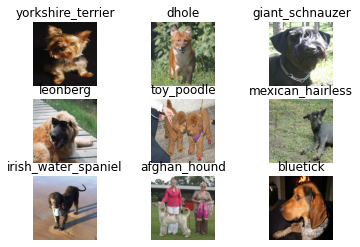

In [9]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

## Data augmentation
We can use preprocessing layers APIs for image augmentation.

In [15]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(mode="horizontal"),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

<ipython-input-16-28cea016ae50>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


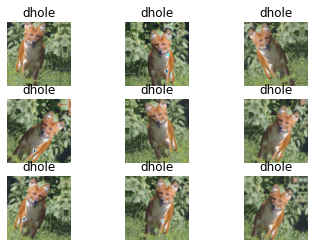

In [16]:
for image, label in ds_train.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [17]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [22]:

#inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#x = img_augmentation(inputs)
#outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)
#model = tf.keras.Model(inputs, outputs)

model = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

In [23]:
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Epoch 1/40
187/187 - 90s - loss: 4.9889 - accuracy: 0.0102 - val_loss: 4.8712 - val_accuracy: 0.0163
Epoch 2/40


KeyboardInterrupt: 